In [1]:
import pandas as pd

In [2]:
dtype = {
    'device_id': 'int64',
    'auctionsMeanHour': 'float64',
    'auctionsCount': 'float64',
    'auctionsMostFreqDay': 'float64',
    'auctionsMeanInstant': 'float64',
    'auctionsMeanInterval': 'float64',
    'auctionsAproxFreq': 'float64',   
}

In [3]:
features = pd.read_csv('data/auctionsFeaturesFirstThreeDays.csv', usecols=dtype.keys(), dtype=dtype)

In [4]:
dtype = {
    'device_id': 'int64',
    'st': 'float64'
}

In [5]:
labels = pd.read_csv('data/labelsFirstThreeDays.csv', usecols=dtype.keys(), dtype=dtype)

In [6]:
labels = labels.merge(features[['device_id']])

In [7]:
labels = labels.sort_values(by='device_id').reset_index(drop=True)

In [8]:
features = features.sort_values(by='device_id').reset_index(drop=True)

In [9]:
features = features.drop('device_id', axis=1)

In [10]:
labels = labels.drop('device_id', axis=1)

In [11]:
labels['uncensored'] = labels['st'].notnull()

In [12]:
secondsInThreeDays = 3 * 24 * 60 * 60
labels['st'] = labels['st'].fillna(secondsInThreeDays)

In [13]:
features = features.fillna(0)

In [14]:
labels.head()

,st,uncensored
0,259200.000000,False
1,259200.000000,False
2,259200.000000,False
3,259200.000000,False
4,88.851558,True


In [15]:
labels['uncensored'].value_counts()

True     230673
False     87652
Name: uncensored, dtype: int64

In [16]:
features.head()

,auctionsMeanHour,auctionsCount,auctionsMostFreqDay,auctionsMeanInstant,auctionsMeanInterval,auctionsAproxFreq
0,4.251317,35.0,3.0,185636.567707,5400.569164,0.000185
1,4.328299,8.0,3.0,188382.438652,23581.596135,0.000042
2,2.895926,6.0,1.0,10425.597361,1748.256831,0.000572
3,23.323611,1.0,3.0,256765.420614,256765.420614,0.000004
4,10.418492,7.0,3.0,160935.721167,36811.037843,0.000027


In [17]:
n1 = 300000
n2 = 10000

In [18]:
labelsTrain = labels.iloc[:n1]

In [19]:
featuresTrain = features.iloc[:n1]

In [20]:
labelsTest = labels.iloc[n1:n1+n2]

In [21]:
featuresTest = features.iloc[n1:n1+n2]

In [22]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
estimator = CoxPHSurvivalAnalysis(verbose=True)

In [62]:
from sksurv.util import Surv
util = Surv()
saLabelsTrain = util.from_dataframe('uncensored', 'st', labelsTrain)
saLabelsTest = util.from_dataframe('uncensored', 'st', labelsTest)

In [52]:
estimator.fit(featuresTrain, saLabelsTrain)

C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=1.08887e-16): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=5.23947e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=3.79946e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-conditioned matrix (rcond=3.57773e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
C:\Users\matias\Anaconda3\lib\site-packages\sksurv\linear_model\coxph.py:330: LinAlgWarning: Ill-con

iter      9: optimization converged


CoxPHSurvivalAnalysis(alpha=0, n_iter=100, tol=1e-09, verbose=True)

In [53]:
pd.Series(estimator.coef_, index=featuresTrain.columns)

auctionsMeanHour        -0.002065
auctionsCount            0.001016
auctionsMostFreqDay     -0.010084
auctionsMeanInstant      0.000004
auctionsMeanInterval    -0.000007
auctionsAproxFreq      -99.161565
dtype: float64

In [54]:
prediction = estimator.predict(featuresTest)

In [55]:
from sksurv.metrics import concordance_index_censored
result = concordance_index_censored(Surv.from_dataframe('uncensored', 'st', labelsTest)['uncensored'], Surv.from_dataframe('uncensored', 'st', labelsTest)["st"], prediction)

In [56]:
result

(0.6440497347255796, 29702464, 16415812, 4, 0)

In [57]:
pred_surv = estimator.predict_survival_function(featuresTest.head(5))

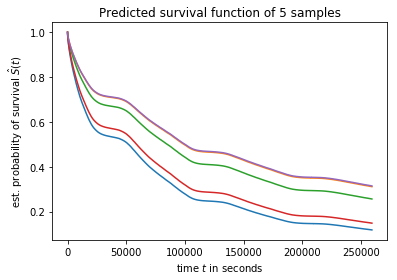

In [59]:
import matplotlib.pyplot as plt
for i, c in enumerate(pred_surv):
    plt.step(c.x, c.y, where="post")
plt.title('Predicted survival function of 5 samples')
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ in seconds")
plt.show()

In [63]:
import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(featuresTest.values, saLabelsTest)
pd.Series(scores, index=featuresTest.columns).sort_values(ascending=False)

auctionsCount           0.650349
auctionsAproxFreq       0.599086
auctionsMeanInterval    0.599086
auctionsMeanInstant     0.555923
auctionsMostFreqDay     0.542150
auctionsMeanHour        0.517326
dtype: float64